In a previous notebook https://github.com/AllenInstitute/aisynphys/blob/master/doc/connectivity_vs_distance.ipynb, we explored the distance dependenc on connectivity and how it can be modeled such that we can reliably compare connection probability among cells of different types probed at different distances. Here we extend that analysis to a number of other features in our dataset that are known to contribute to our ability to estimate the true, in vivo, connection probability. These factors fall into two main categories, those related to affects on neuronal processes due to the slicing procedure and our ability to detect small connections in noisy electrophysiological recordings.

Multipatch slice electrophysiology is one of the best methods for indepth characterization of synaptic connections. However, a consistent criticism  of slice physgiology is that measured connection probability (Cp) is a lower bounds of the true Cp due to severing of processes during slicing. We took multiple steps to reduce this liklihood in our dataset including the use of relatively thick slices (350um), targeting cells deep into the slice (at least 40um) and close together (typically 100um). We have additional measurements of axon and apical dendrite length before truncation from biocytin fills of recorded cells which we may use to estimage the affect on connection probability. 

It is also the case that electrophysiological recordings contain some amount of baseline noise. The level of this can be cell type dependent and may obscure very small responses unless we can average many many responses together, which is ultimately related to how long we record from the cells.

This notebook will explore these data and the impact it might have on Cp.

First let's import a bunch of stuff we might need including the database which holds all of our data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from aisynphys.database import default_db as db
from aisynphys.cell_class import CellClass, classify_cells, classify_pairs
from aisynphys.connectivity import measure_connectivity, connectivity_profile, pair_was_probed, measure_distance, GaussianModel, LinearModel, ExpModel
from aisynphys.ui.notebook import show_connectivity_profile, show_distance_binned_cp, show_connectivity_raster, show_connectivity_fit, set_distance_xticks
print(db.schema_version)

18


Make excitatory and inhibitory cell class and pull out some pairs

In [69]:
# select all excitatory / inhibitory pairs
kwargs = {
    'project_name': ["mouse V1 coarse matrix", "mouse V1 pre-production"],
}
ex_pairs = db.pair_query(pre_class=CellClass(cell_class_nonsynaptic='ex'), **kwargs).all()
in_pairs = db.pair_query(pre_class=CellClass(cell_class_nonsynaptic='in'), **kwargs).all()

# filter pairs on several criteria:
def check_pair(p, syn_type):
    return (
        # must have been probed for connectivity
        pair_was_probed(p, syn_type) and
        # must have a true/false connection call
        p.has_synapse is not None and
        # intersomatic distance < 500 µm (removes some bad data with very large distances)
        p.distance is not None and 
        p.distance < 500e-6
    )
ex_pairs = [p for p in ex_pairs if check_pair(p, 'ex')]
in_pairs = [p for p in in_pairs if check_pair(p, 'in')]
all_pairs = np.concatenate([ex_pairs, in_pairs])

# get intersomatic distances
ex_dist = np.array([p.distance for p in ex_pairs])
ex_lat_dist = np.array([p.lateral_distance for p in ex_pairs])
in_dist = np.array([p.distance for p in in_pairs])
in_lat_dist = np.array([p.lateral_distance for p in in_pairs])
all_dist = np.concatenate([ex_dist, in_dist])
all_lat_dist = np.concatenate([ex_lat_dist, in_lat_dist])

# get connectivity
ex_conn = np.array([p.has_synapse for p in ex_pairs], dtype=bool)
in_conn = np.array([p.has_synapse for p in in_pairs], dtype=bool)
all_conn = np.concatenate([ex_conn, in_conn])

In [70]:
def pre_axon_length(pair):
    cell_morph = pair.pre_cell.morphology
    if cell_morph is None:
        return np.nan
    if cell_morph.axon_trunc_distance is not None:
        return cell_morph.axon_trunc_distance
    elif cell_morph.axon_truncation == 'intact':
        return 200e-6
    
def avg_pair_depth(pair):
    if pair.pre_cell.depth is None or pair.post_cell.depth is None:
        return np.nan
    avg_depth = np.mean([pair.pre_cell.depth, pair.post_cell.depth])
    if avg_depth < 0 or avg_depth > 300e-6:
        return np.nan
    return avg_depth

def n_test_spikes(pair):
    syn_type = pair.pre_cell.cell_class_nonsynaptic
    if syn_type not in ['ex', 'in']:
        return np.nan
    
    q = db.query(db.StimPulse.n_spikes)
    q = q.join(db.PulseResponse)
    q = q.filter(db.PulseResponse.pair_id==pair.id)
    q = q.join(db.PatchClampRecording, db.PatchClampRecording.recording_id==db.StimPulse.recording_id).join(db.MultiPatchProbe)
    
    q = q.filter(db.MultiPatchProbe.induction_frequency <= 50)
    q = q.filter(db.StimPulse.n_spikes==1)
    q = q.filter(db.StimPulse.first_spike_time is not None)
    
    if syn_type == 'ex':
        q = q.filter(db.PatchClampRecording.baseline_potential.between(-80e-3, -60e-3))\
            .filter(db.PulseResponse.ex_qc_pass==True)
    elif syn_type == 'in':
        q = q.filter(db.PatchClampRecording.baseline_potential.between(-60e-3, -45e-3))\
            .filter(db.PulseResponse.in_qc_pass==True)

    return(q.count())              

def baseline_rms_noise(pair):
    post_cell = pair.post_cell
    q = db.query(db.PatchClampRecording)
    q = q.join(db.Recording).join(db.Electrode).join(db.Cell)
    q = q.filter(db.Cell.id==post_cell.id).filter(db.PatchClampRecording.clamp_mode=='ic')
    pcrs = q.all()
    pcr_noise = [pcr.baseline_rms_noise for pcr in pcrs if pcr.qc_pass]
    if len(pcr_noise) > 1:
        return np.mean(pcr_noise)
    else:
        return np.nan

Calculate some metrics that we want to investigate with relation to connectivity

In [79]:
import time
# takes about an hour to run
mouse_e_pairs = {'pairs': ex_pairs, 'distance': ex_dist, 'lateral_distance': ex_lat_dist, 'has_synapse': ex_conn}
mouse_i_pairs = {'pairs': in_pairs, 'distance': in_dist, 'lateral_distance': in_lat_dist, 'has_synapse': in_conn}

start = time.time()
for pair_group in [mouse_e_pairs, mouse_i_pairs]:
    pairs = pair_group['pairs']
    pair_group['pre_axon_trunc_dist'] = [pre_axon_length(p) for p in pairs]
    pair_group['avg_pair_depth'] = [avg_pair_depth(p) for p in pairs]
    pair_group['n_test_spikes'] = [n_test_spikes(p) for p in pairs]
    pair_group['baseline_rms_noise'] = [baseline_rms_noise(p) for p in pairs]
end = time.time()
print((end-start)/60)

56.697656671206154


In [81]:
mouse_pairs = {
    'pairs': all_pairs, 
    'distance': all_dist, 
    'lateral_distance': all_lat_dist,
    'has_synapse': all_conn,
    'pre_axon_trunc_dist': np.concatenate([mouse_e_pairs['pre_axon_trunc_dist'], mouse_i_pairs['pre_axon_trunc_dist']]),
    'avg_pair_depth': np.concatenate([mouse_e_pairs['avg_pair_depth'], mouse_i_pairs['avg_pair_depth']]),    
    'n_test_spikes': np.concatenate([mouse_e_pairs['n_test_spikes'], mouse_i_pairs['n_test_spikes']]),
    'baseline_rms_noise': np.concatenate([mouse_e_pairs['baseline_rms_noise'], mouse_i_pairs['baseline_rms_noise']]),
}

mouse_e_pairs['lateral_distance'] = ex_lat_dist
mouse_i_pairs['lateral_distance'] = in_lat_dist

In [82]:
dtypes= {
    'lateral_distance': 'float',
    'pre_axon_trunc_dist': 'float',
    'avg_pair_depth': 'float',
    'baseline_rms_noise': 'float',
}
mouse_pairs = pd.DataFrame.from_dict(mouse_pairs).astype(dtypes)
e_pairs = pd.DataFrame.from_dict(mouse_e_pairs).astype(dtypes)
i_pairs = pd.DataFrame.from_dict(mouse_i_pairs).astype(dtypes)

print(len(mouse_pairs))
mouse_pairs.head()

19681


,pairs,distance,lateral_distance,has_synapse,pre_axon_trunc_dist,avg_pair_depth,n_test_spikes,baseline_rms_noise
0,<Pair 1506537287.635 5 8>,0.000227,0.000226,False,NaN,0.000106,912,0.000245
1,<Pair 1506537287.635 6 4>,0.000096,0.000096,False,0.0002,0.000102,1020,0.000496
2,<Pair 1506537287.635 6 5>,0.000115,0.000113,False,0.0002,0.000110,1020,0.000603
3,<Pair 1506537287.635 6 7>,0.000095,0.000090,True,0.0002,0.000112,996,0.000231
4,<Pair 1506537287.635 6 8>,0.000114,0.000113,False,0.0002,0.000099,1020,0.000245


Some ease of use functions for plotting and extenstion of our ConnectivityModel to include a Sigmoid curve. 

In [83]:
from aisynphys.connectivity import ConnectivityModel

class SigmoidModel(ConnectivityModel):
    def __init__(self, pmax, size):
        self.pmax = pmax
        self.size = size

    def connection_probability(self, x):
        return (self.pmax / (1 + np.exp(-1 / self.size *(x - self.size))))
    

def cp_vs_x(probed, conn, ax, x_bins=np.arange(0, 500e-6, 40e-6), alpha=[0.005, 0.05], x_label='', ymax=0.3, scale=1e6):

    tickheight = ymax / 10
    offset = 2
    x_vals = np.linspace(x_bins[0], x_bins[-1], 200)
    
    _, cprop, lower, upper = connectivity_profile(conn, probed, x_bins)
    show_distance_binned_cp(x_bins, cprop, ax, ci_lower=lower, ci_upper=upper)
    
    ax.eventplot(probed.copy(), lineoffsets=-tickheight*offset, linelengths=tickheight, color=((0, 0, 0) + (alpha[0],)))
    ax.eventplot(probed[conn], lineoffsets=-tickheight*(offset-1), linelengths=tickheight, color=((0, 0, 0) + (alpha[1],)))
    ax.axhline(0, color=(0, 0, 0))
    
    interval = x_bins[1] - x_bins[0]
    xticks = np.arange(0, x_vals.max(), interval)
    ax.set_xticks(xticks)
    tick_labels = ['%0.1f'%(x*scale) for x in xticks]
    trailing_zero = [label.strip('.')[-1] == '0' for label in tick_labels]
    if all(trailing_zero):
        tick_labels = ['%0.0f'%(x*scale) for x in xticks] 
    ax.set_xticklabels(tick_labels, fontsize=10)
    ax.set_xlim(x_bins[0], x_bins[-1])
    
    y_vals = np.arange(0, ymax + 0.1, 0.1)
    ax.set_yticks([-tickheight*2, -tickheight] + list(y_vals))
    ax.set_yticklabels(['probed', 'connected'] + ['%0.1f'%x for x in y_vals], fontsize=10)
    ax.set_ylim(-tickheight*2.6, ymax)
    ax.set_xlabel(x_label, fontsize=12)
    
    return cprop
    
def cp_fit_x(data_df, x, ax, fit_label=None, units='µm', scale=1e6, x_bins=np.arange(0, 500e-6, 40e-6), color=(0.5, 0, 0),  
             model=GaussianModel, fixed_size=None, fixed_max=None, init=(0.1, 150e-6), bounds=((0.001, 1), (10e-6, 1e-3))):
    x_vals = np.linspace(x_bins[0], x_bins[-1], 200)
    probed = data_df[x].to_numpy(dtype='float')
    conn = data_df['has_synapse'].to_numpy(dtype='bool')
    mask = np.isfinite(probed) & np.isfinite(conn)
    fit = model.fit(probed[mask], conn[mask], fixed_size=fixed_size, fixed_max=fixed_max, init=init, bounds=bounds)
    if 'distance' in x:
        set_distance_xticks(x_vals, ax)
    else:
        ax.axhline(fit.pmax, color=color, ls='--')
    if fit_label is not None:
        label = 'pmax: %0.2f, size: %0.2f%s' % (fit.pmax, fit.size*scale, units)
        ax.plot(x_vals, fit.connection_probability(x_vals), color=color, label=label, lw=3)
        ax.legend(loc='upper right')
    else:
        ax.plot(x_vals, fit.connection_probability(x_vals), color=color, lw=3)

    return fit

OK, let's look at how Connection Proabability is related to these metrics and how we might fit them to a model. We will also look at the influence of how thresholding data for each of these metrics influences our previous estimate of connectivity as a function of intersomatic distance. Ultimately we would like to generate a model that encompasses all of these factors along with intersomatic distance to describe and correct our connection probability estimates.

Text(0.5, 1.0, 'Distribution for all pairs')

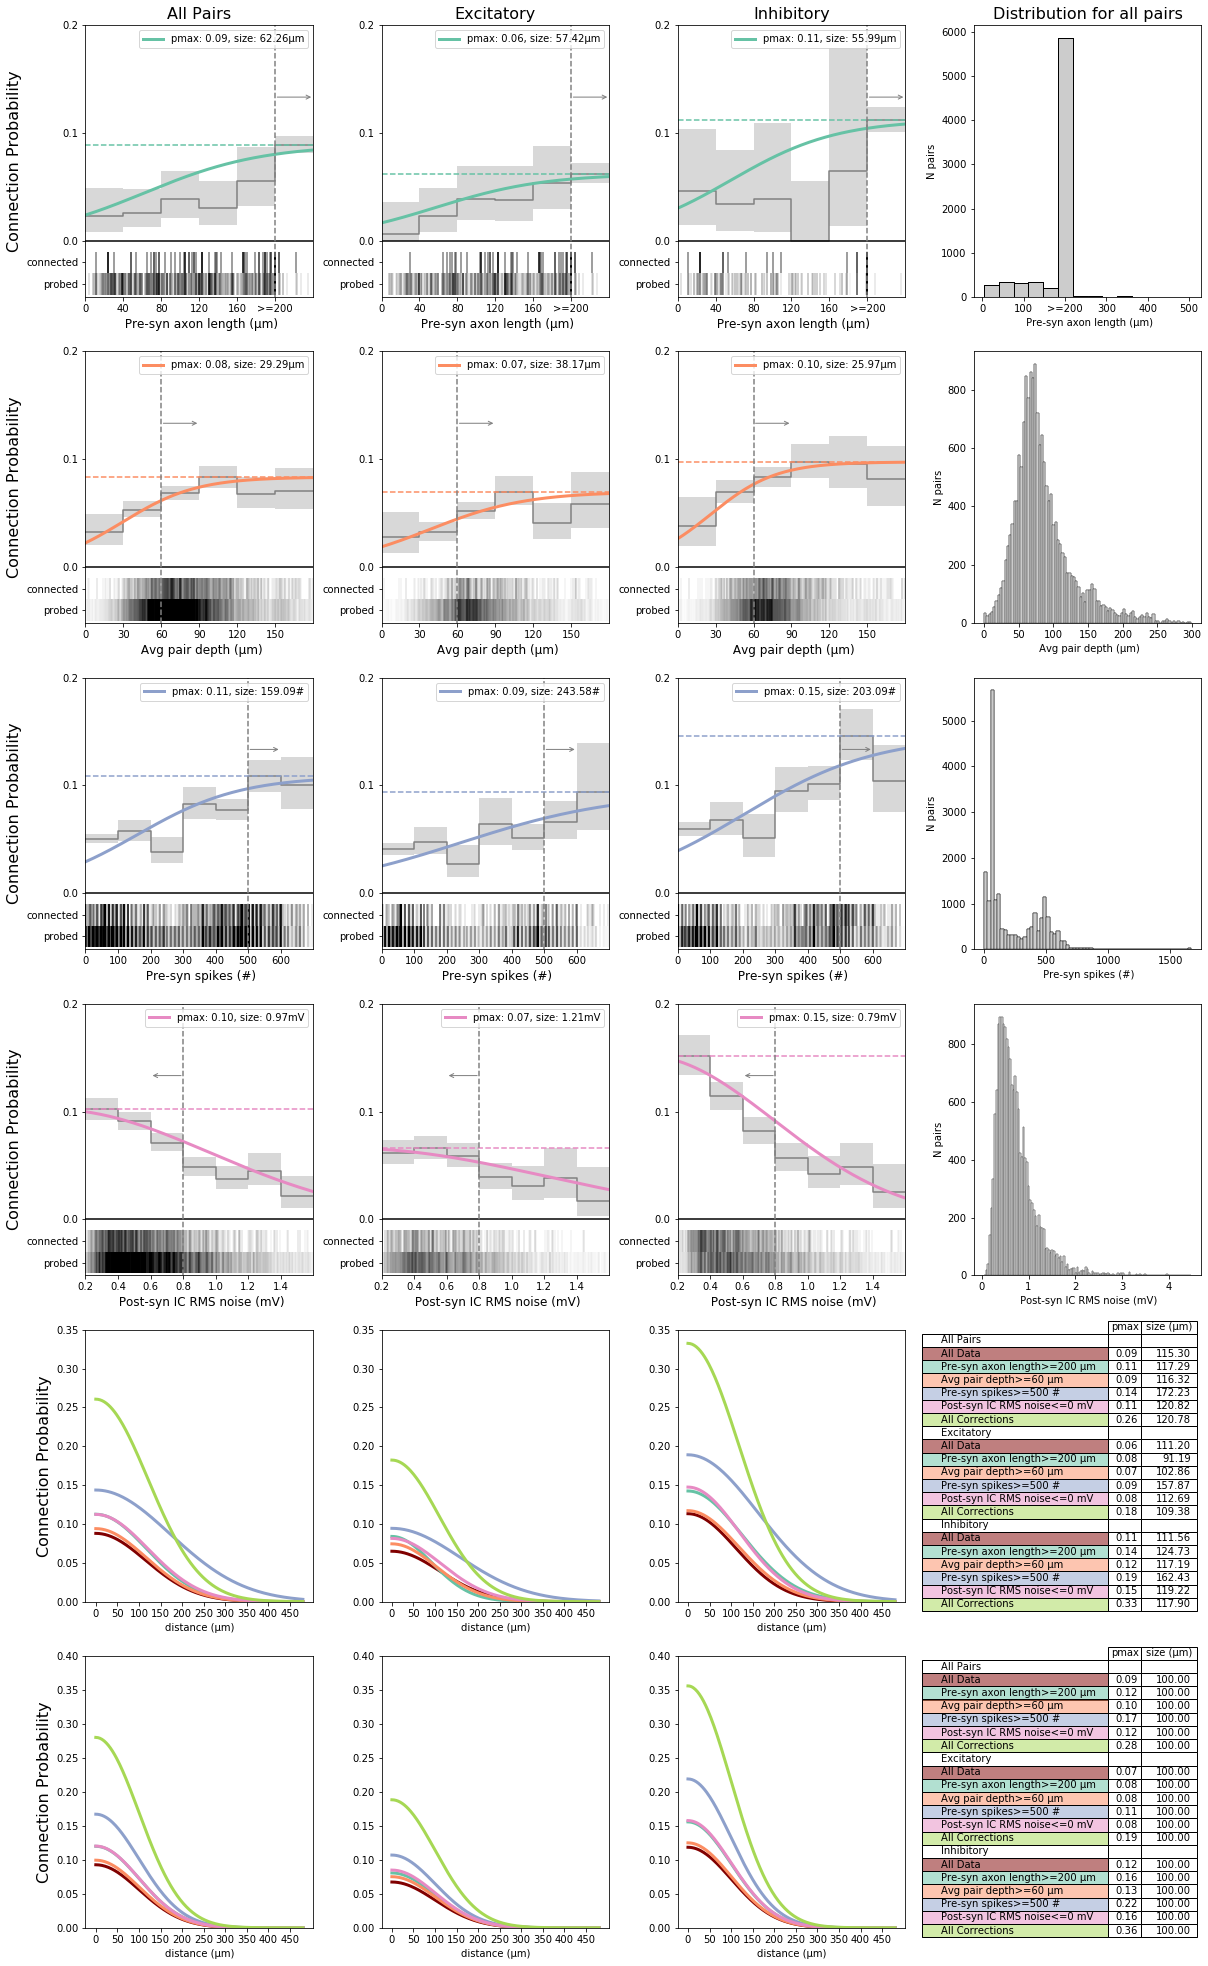

In [86]:

mouse_data = {'All Pairs': mouse_pairs, 'Excitatory': e_pairs, 'Inhibitory': i_pairs}
## Let's set up some metrics we want to look at. These dictionaries describe how we want the data to be binned, thresholded,
## and plotted
metrics = {
#         'distance': {'ymax': 0.2, 'xbins': np.arange(0, 500e-6, 40e-6), 'label': 'Intersomatic distance', 'alpha':[0.05, 0.5],
#                      'units': ('µm', 1e6), 'model': GaussianModel},
        'pre_axon_trunc_dist': {'ymax': 0.2, 'xbins': np.arange(0, 280e-6, 40e-6), 'alpha':[0.05, 0.5], 'fixed_max': True,
                               'threshold': (200e-6, 'lower'), 'label': 'Pre-syn axon length', 'units': ('µm', 1e6)}, 
        'avg_pair_depth': {'ymax': 0.2, 'xbins': np.arange(0, 200e-6, 30e-6), 'alpha': [0.005, 0.05], 'threshold': (60e-6, 'lower'),
                     'label': 'Avg pair depth', 'units': ('µm', 1e6), 'fixed_max': True},
        'n_test_spikes': {'ymax': 0.2, 'xbins': np.arange(0, 800, 100), 'alpha': [0.01, 0.1], 'threshold': (500, 'lower'),
                          'units': ('#', 1), 'label': 'Pre-syn spikes', 'init': (0.05, 1000), 'bounds': ((0.001, 1), (10, 10e3)),
                         'fixed_max': True},
#         'n_syn': {'ymax': 0.4, 'xbins': np.arange(0, 12, 2), 'alpha': [0.005, 0.05], 'threshold': 2, 'label': '# Synapses',
#                   'init':(0.05, 3), 'bounds': ((0.001, 1), (0, 20))},
        'baseline_rms_noise': {'ymax': 0.2, 'xbins': np.arange(0.2e-3, 1.8e-3, 0.2e-3), 'alpha': [0.005, 0.05], 
                                   'units': ('mV', 1e3), 'label': 'Post-syn IC RMS noise', 'init': (0.05, 0.5e-3), 
                                   'bounds': ((0.001, 1),(0.2e-3, 3e-3)), 'model': GaussianModel, 'fixed_max': True,
                                  'threshold': (0.8e-3, 'upper')},
#         'post_cell_vc_rms_noise': {'ymax': 0.2, 'xbins': np.arange(3e-12, 50e-12, 5e-12), 'alpha': [0.005, 0.05],
#                                    'units': ('pA', 1e12), 'label': 'Post VC Noise', 'init': (0.05, 50e-12), 
#                                    'bounds': ((0.001, 1),(1e-12, 100e-12)), 'model': GaussianModel}
}

colors = sns.color_palette("Set2", n_colors=len(metrics) + 1)

cell_text = []
cell_text_fixed = []
columns = ('pmax', 'size (µm)')
rows = []
cell_colors = []

fig, axs = plt.subplots(len(metrics) + 2, 4, figsize=(20, 35))

plt.subplots_adjust(hspace=0.2, wspace=0.3)

[axs[a, 0].set_ylabel('Connection Probability', fontsize=16) for a in range(0, len(metrics)+2)]

## Work through each of our 3 datasets, all mouse pairs, excitatory connections, and inhibitory connections
for i, (name, data) in enumerate(mouse_data.items()):
    rows.append(name)
    cell_text.append(['',''])
    cell_text_fixed.append(['', ''])
    cell_colors.append('w')
    axs[0, i].set_title(name, fontsize=16)
    #Cp vs intersomatic distance
    conn = data['has_synapse'].to_numpy(dtype='bool')
    dist_bins = np.arange(0, 500e-6, 40e-6)
    dist_fit = cp_fit_x(data, 'lateral_distance', axs[-2, i], x_bins=dist_bins)
    rows.append('All Data')
    cell_text.append(['%0.2f' % dist_fit.pmax, '%0.2f' % (dist_fit.size*1e6)])
    cell_colors.append((0.5, 0, 0, 0.5))
    
    fixed_size = 100e-6
    dist_fit_fixed_size = cp_fit_x(data, 'lateral_distance', axs[-1, i], x_bins=dist_bins, fixed_size=fixed_size)
#     cp_vs_x(data['distance'].to_numpy(dtype='float'), conn, ax)
    cell_text_fixed.append(['%0.2f' % dist_fit_fixed_size.pmax, '%0.2f' % (dist_fit_fixed_size.size*1e6)])
    
    all_corrections = data.copy()
    # For each metric, plot the binned relationship with connection probability and attempt to fit
    for j, (metric, params) in enumerate(metrics.items()):
        ax  = axs[j, i]
        probed = data[metric].to_numpy(dtype='float')
        xbins = params['xbins']
        alpha = params['alpha']
        ymax = params['ymax']
        unit, scale = params['units']
        x_label = " %s (%s)" % (params['label'], unit)
        model = params.get('model', SigmoidModel)
        
        cprop = cp_vs_x(probed, conn, ax, x_bins=xbins, alpha=alpha, x_label=x_label, ymax=ymax, scale=scale)
        if 'axon' in metric:
            xtick_labels = ax.get_xticklabels()
            ind_200 = [i for i, tl in enumerate(xtick_labels) if tl.get_text()=='200'][0]
            xtick_labels[ind_200] = '>=200'
            ax.set_xticklabels(xtick_labels)
        
        init = params.get('init', (0.1, 150e-6))
        bounds = params.get('bounds', ((0.001, 1), (10e-6, 1e-3)))
        
        fixed_max = params.get('fixed_max', None)
        if fixed_max is True:
            fixed_max = np.max(cprop)
        fit = cp_fit_x(data, metric, ax,  fit_label='', units=unit, scale=scale, x_bins=xbins, color=colors[j], 
                       model=model, init=init, bounds=bounds, fixed_max=fixed_max)
        
        # Show metric distribution for reference
        sns.histplot(x=metric, data=mouse_pairs, ax=axs[j, 3], color=(0.8, 0.8, 0.8))
        xticks = axs[j, 3].get_xticks()
        xtick_labels = ['%0.0f' % (x*scale) for x in xticks]
        if 'axon' in metric:
            ind_200 = [i for i, tl in enumerate(xtick_labels) if tl=='200'][0]
            xtick_labels[ind_200] = '>=200'
        axs[j, 3].set_xticklabels(xtick_labels)
        axs[j, 3].set_xlabel(x_label)
        axs[j, 3].set_ylabel('N pairs')
        
        # If we can set a threshold where we think Cp levels off, reduce data to values >= / <= to that, depending
        # on the bounds and recompute. Accumulate all of these corrections into one final correction on 
        # Cp vs intersomatic distance fit
        threshold, bound = params.get('threshold')
        if threshold is not None:
            ax.axvline(threshold, color=(0.5, 0.5, 0.5), ls='--')
            if bound == 'lower':
                corrected_data = data[data[metric] >= threshold]
                all_corrections = all_corrections[all_corrections[metric] >= threshold]
                label = "%s>=%d %s" % (params['label'], threshold*scale, unit)
                ax.annotate('', xy=(threshold+(xbins[1]-xbins[0]), ymax-ymax/3), xytext=(threshold, ymax-ymax/3),
                            arrowprops={'arrowstyle': '->', 'color': (0.5, 0.5, 0.5)})
            if bound == 'upper':
                corrected_data = data[data[metric] <= threshold]
                all_corrections = all_corrections[all_corrections[metric] <= threshold]
                label = "%s<=%d %s" % (params['label'], threshold*scale, unit)
                ax.annotate('', xy=(threshold, ymax-ymax/3), xytext=(threshold-(xbins[1]-xbins[0]), ymax-ymax/3),
                            arrowprops={'arrowstyle': '<-', 'color': (0.5, 0.5, 0.5)})

            corrected_fit = cp_fit_x(corrected_data, 'lateral_distance', axs[-2, i], 
                                     x_bins=dist_bins, color=colors[j])
            corrected_fit_fixed_size = cp_fit_x(corrected_data, 'lateral_distance', axs[-1, i],  
                                                x_bins=dist_bins, color=colors[j], fixed_size=fixed_size)
            rows.append(label)
            cell_text.append(['%0.2f' % corrected_fit.pmax, '%0.2f' % (corrected_fit.size*1e6)])
            cell_text_fixed.append(['%0.2f' % corrected_fit_fixed_size.pmax, '%0.2f' % (corrected_fit_fixed_size.size*1e6)])
            cell_colors.append(colors[j] + (0.5,))
    
    # Cp vs intersomatic distance fit to all corrections
    all_corr_fit = cp_fit_x(all_corrections, 'lateral_distance', axs[-2, i], x_bins=dist_bins, 
             color=colors[-1])
    axs[-2, i].set_ylim(0, 0.35)
    all_corr_fit_fixed_size = cp_fit_x(all_corrections, 'lateral_distance', axs[-1, i], x_bins=dist_bins, 
             color=colors[-1], fixed_size=fixed_size)
    axs[-1, i].set_ylim(0, 0.4)
    rows.append('All Corrections')
    cell_text.append(['%0.2f' % all_corr_fit.pmax, '%0.2f' % (all_corr_fit.size*1e6)])
    cell_text_fixed.append(['%0.2f' % all_corr_fit_fixed_size.pmax, '%0.2f' % (all_corr_fit_fixed_size.size*1e6)])
    cell_colors.append(colors[-1] + (0.5,))

    
axs[-2, -1].axis("off")
axs[-1, -1].axis("off")

table = axs[-2, -1].table(cellText=cell_text,
                          rowLabels=rows,
                          rowColours=cell_colors,
                          colLabels=columns,
                          loc='center right')
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(columns))))
table.scale(1,1.1)

table_fixed = axs[-1, -1].table(cellText=cell_text_fixed,
                          rowLabels=rows,
                          rowColours=cell_colors,
                          colLabels=columns,
                          loc='center right')
table_fixed.set_fontsize(10)
table_fixed.auto_set_column_width(col=list(range(len(columns))))
table_fixed.scale(1, 1.1)

axs[0, -1].set_title('Distribution for all pairs', fontsize=16)


In the plots above (top 4 rows) we see binned Connection Proabability vs X with a 95% confidence interval as the grey step line and shading. The raster below that shows a tick in the upper row if a connection was found at that value and the bottom row each tick represents a connection probed at that value. The colored line shows the model fit of the data with the colored dashed line being the fixed pmax value. We found that it was necessary to fix this value in order to get a reasonable fit to the data. The vertical grey dashed line depicts the threshold applied for use in calculating the correction. The direction of the arrow indicates what data was included. The histograms at the end of each row show the distribution of values for that metric. The bottom two rows show Gaussain fits to the Connection Probability vs intersomatic distance with either a free sigma value (top) or a fixed sigma value (bottom). The dark red curve is our baseline Cp vs Distance without any correction. Each colored line depicts the affect on the fit if the data is thresholded for that metric. For exampe, the pink curve shows the fit for data in which the postsynaptic noise level was <= 1mV. The lime green line shows the cummulative affect of all corrections. The tables to the right list the pmax and sigma values of each fit.